In [249]:
## Text Mining Project
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import re
import lyricsgenius
import time
import spacy
from gensim.corpora import Dictionary
from gensim.models import Phrases
from gensim.models import LdaModel
import logging
from gensim.models import CoherenceModel
from operator import itemgetter
from collections import Counter
import pyLDAvis.gensim
import pickle 
import pyLDAvis
import sklearn
from gensim.test.utils import datapath
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import euclidean_distances
import heapq
import math
from scipy.spatial import distance_matrix
from adjustText import adjust_text
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

In [4]:
all_artists = ['187 Strassenbande', 'AK Ausserkontrolle', 'Alligatoah', 'Apache 207', 'Azad', 'Azet', 'badmómzjay', 'Bausa', 'Beginner', 'Bonez MC', 'Bushido', 'Capital Bra', 'Casper', 'Celo & Abdi', 'Chakuza', 'Cro', 'Culcha Candela', 'CÉLINE', 'Dardan', 'Deichkind', 'Die Atzen', 'Die Fantastischen Vier', 'Eko Fresh', 'Eno', 'Farid Bang', 'Fero47', 'Fettes Brot', 'Fler', 'Freundeskreis', 'Genetikk', 'Gzuz', 'Haftbefehl', 'Jamule', 'Jan Delay', 'Joker Bra', 'Juju', 'K.I.Z', 'KC Rebell', 'Kay One', 'Kollegah', 'Kontra K', 'Kool Savas', 'Kraftklub', 'Loredana', 'Luciano', 'MERO', 'Marteria', 'Max Herre', 'MoTrip', 'Money Boy', 'Moses Pelham', 'Nimo', 'Olexesh', 'Peter Fox', 'Prinz Pi', 'RAF Camora', 'RIN', 'Rödelheim Hartreim Projekt', 'SSIO', 'SXTN', 'Sabrina Setlur', 'Samra', 'Samy Deluxe', 'Seeed', 'Shindy', 'Sido', 'Silla', 'Summer Cem', 'Tic Tac Toe', 'Trailerpark', 'Trettmann', 'Ufo361', 'Veysel', 'XATAR', 'Xavas', 'Yung Hurn', 'Zuna']

In [100]:
# Genius token - https://genius.com/api-clients
# Library - https://github.com/johnwmillr/LyricsGenius
token = "KbIhkIUKtt6IqQnUWh7KwZXWU8d-FduTSQfCnJWHQh97BVs07PisfSWIYs0uAwX6"
genius = lyricsgenius.Genius(token)

In [3]:
# Download the lyrics
for artist_name in all_artists:
    try:
        artist = genius.search_artist(artist_name, sort="title")
        artist.save_lyrics()
    except:
        time.sleep(300)
        artist = genius.search_artist(artist_name, sort="title")
        artist.save_lyrics()

In [6]:
# Store lyrics and relevant metadata in dataframe
all_songs = pd.DataFrame(columns = ['Title', 'Artist', 'Release', 'Lyrics'])

for artist_name in all_artists:
    print(artist_name)
    # Extract data from the json files
    with open(f'Lyrics_{artist_name.replace(" ", "").replace("&", "")}.json') as json_file:
        data = json.load(json_file)
        
        for song in data['songs']:
            title = song['title']
            release = song['release_date']
            lyrics_raw_raw = song['lyrics']
            # Exclude songs without lyrics or release date, songs that contain brackets () [] and commentaries
            if lyrics_raw_raw != None and release != None and not re.search(r' \(.*?\)| \[.*?\]', title) and 'Commentary' not in title:
                # Remove line breaks from lyrics
                lyrics_raw = lyrics_raw_raw.replace('\n', ' ')
                # Remove brackets from the lyrics, as they only contain meta info and calls e.g. [Hook], (yeah!)                
                lyrics = re.sub(r"[\[].*?[\]]|[\(].*?[\)]", "", lyrics_raw)
                # Filter lyrics with english parts by best effort
                if not re.search('(?=.* the )(?=.* you )(?=.* and )', lyrics):
                    new_song = {'Title': title, 'Artist': artist_name, 'Release': release, 'Lyrics': lyrics}
                    all_songs = all_songs.append(new_song, ignore_index=True)
                    
all_songs['Release'] = all_songs['Release'].map(lambda date: date[:-6])

187 Strassenbande
AK Ausserkontrolle
Alligatoah
Apache 207
Azad
Azet
badmómzjay
Bausa
Beginner
Bonez MC
Bushido
Capital Bra
Casper
Celo & Abdi
Chakuza
Cro
Culcha Candela
CÉLINE
Dardan
Deichkind
Die Atzen
Die Fantastischen Vier
Eko Fresh
Eno
Farid Bang
Fero47
Fettes Brot
Fler
Freundeskreis
Genetikk
Gzuz
Haftbefehl
Jamule
Jan Delay
Joker Bra
Juju
K.I.Z
KC Rebell
Kay One
Kollegah
Kontra K
Kool Savas
Kraftklub
Loredana
Luciano
MERO
Marteria
Max Herre
MoTrip
Money Boy
Moses Pelham
Nimo
Olexesh
Peter Fox
Prinz Pi
RAF Camora
RIN
Rödelheim Hartreim Projekt
SSIO
SXTN
Sabrina Setlur
Samra
Samy Deluxe
Seeed
Shindy
Sido
Silla
Summer Cem
Tic Tac Toe
Trailerpark
Trettmann
Ufo361
Veysel
XATAR
Xavas
Yung Hurn
Zuna


In [75]:
sw = list(en_stop_words) + manual_stop_words + list(nlp.Defaults.stop_words)

k = 5
vectorizer = TfidfVectorizer(stop_words=sw, use_idf=True)
lyrics = vectorizer.fit_transform(all_songs['Lyrics'])
kmeans = KMeans(n_clusters=k, n_init=20).fit(lyrics)

features = vectorizer.get_feature_names()

cluster_centers = kmeans.cluster_centers_

for c in cluster_centers:
  index = heapq.nlargest(k, range(len(c)), c.take)
  for i in index:
    print(features[i])
  print("\n")

/home/luca/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:391: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


la
bam
mero
money
mama


yeah
rap
rapper
fick
hab


baby
oh
komm
ey
sag


hab
ey
ne
ah
money


hab
leben
weg
weiß
welt




In [13]:
nlp = spacy.load('de_core_news_lg')
nlp_en = spacy.load('en')

In [14]:
# Preprocessing
docs = []

print('Tokenizing and removing stop words')
# Tokenization and Lemmatization (remove stop words, numbers and one/two character words)
for index, song in all_songs.iterrows():
    # Remove the artist name from the lyrics
    doc = nlp(song['Lyrics'].replace(song['Artist'],''))
    lemmatized_doc = [token.lemma_ for token in doc if not token.is_stop and token.lemma_.isalpha() and len(token)>2]
    docs.append(lemmatized_doc)

# Remove english stop words and few manual stop words
manual_stop_words = ['ein', 'eine', 'mal', 'mach', 'lass', 'nich', 'sein', 'nix', 'tun', 'mein']
en_stop_words = nlp_en.Defaults.stop_words
docs = [[word for word in doc if not word.lower() in en_stop_words and not word.lower() in manual_stop_words] for doc in docs]

# Add bigrams/trigrams that appear 5 times or more (song texts are short)
bigram = Phrases(docs, min_count=5)
trigram = Phrases(bigram[docs], min_count=5)
print(f'Adding {len(bigram.vocab)} bigrams and {len(trigram.vocab)} trigrams')

for idx in range(len(docs)):
    for token in trigram[bigram[docs[idx]]]:
        if '_' in token:
            docs[idx].append(token)
    
# Filter extremes, these values seem to work well
dictionary = Dictionary(docs)
print(f'Filtering extremes - Number of unique tokens: {len(dictionary)}')
dictionary.filter_extremes(no_below=15, no_above=0.5)

print('Computing BoW representation')
# Bag-of-words representation of the documents
corpus = [dictionary.doc2bow(doc) for doc in docs]

temp = dictionary[0]
id2word = dictionary.id2token

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Tokenizing and removing stop words
Adding 936232 bigrams and 959381 trigrams
Filtering extremes - Number of unique tokens: 108140
Computing BoW representation
Number of unique tokens: 8195
Number of documents: 7467


In [6]:
def plot_passes(filename, passes):
    matcher = re.compile('(-*\d+\.\d+) per-word .* (\d+\.\d+) perplexity')
    likelihoods = []
    with open(filename) as source:
        for line in source:
            match = matcher.search(line)
            if match:
                likelihoods.append(float(match.group(1)))
    plt.plot(np.arange(0,passes,1), likelihoods, c="black")
    plt.ylabel("log liklihood")
    plt.xlabel("pass")
    plt.title("Topic Model Convergence")
    plt.grid()
    plt.show()

In [7]:
def create_logfile(filename):
    for handler in logging.root.handlers[:]:
        logging.root.removeHandler(handler)
    logging.basicConfig(filename=filename,
                        format="%(asctime)s:%(levelname)s:%(message)s",
                        level=logging.INFO)

In [8]:
def get_coherence_score(lda_model):
    coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    return coherence_lda

In [ ]:
chunksize = 1000
passes = 100
iterations = 1000
random_state = 973525

model_results = {'Topics': [], 'Alpha': [], 'Beta': [], 'Coherence': []}
topics_range = range(4, 16)
alpha = [0.01, 1, 0.3, 'auto']
beta = [0.01, 1, 0.3, 'auto']

for t in topics_range:
    for a in alpha:
        for b in beta:  
            lda_model = LdaModel(
                     corpus=corpus,
                     id2word=id2word,
                     num_topics=t,
                     passes=passes,
                     iterations=iterations,
                     chunksize=chunksize,
                     alpha=a,
                     eta=b,
                     random_state=random_state
            )
            cv = get_coherence_score(lda_model)
            model_results['Topics'].append(t)
            model_results['Alpha'].append(a)
            model_results['Beta'].append(b)
            model_results['Coherence'].append(cv)
            print(cv)

In [20]:
index, element = max(enumerate(model_results['Coherence']), key=itemgetter(1))

print(model_results['Topics'][index])
print(model_results['Alpha'][index])
print(model_results['Beta'][index])
print(model_results['Coherence'][index])

10
auto
auto
0.4574865803627299


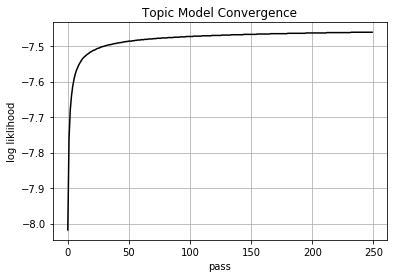

10 Topics:


[(0,
  '0.022*"Leben" + 0.016*"Welt" + 0.012*"sehen" + 0.011*"bleiben" + 0.009*"weiß" + 0.009*"Gott" + 0.008*"Herz" + 0.008*"lieben" + 0.008*"Auge" + 0.007*"Weg" + 0.007*"Mensch" + 0.007*"leben" + 0.007*"Traum" + 0.006*"tun" + 0.005*"Nacht" + 0.005*"seh" + 0.005*"sterben" + 0.005*"Licht" + 0.005*"Kopf" + 0.004*"glauben"'),
 (1,
  '0.032*"mal" + 0.013*"Mann" + 0.011*"sagen" + 0.011*"eine" + 0.009*"Frau" + 0.009*"mach" + 0.009*"einfach" + 0.008*"stehen" + 0.007*"denken" + 0.007*"Leute" + 0.007*"fragen" + 0.006*"sag" + 0.006*"nix" + 0.006*"weg" + 0.006*"Haus" + 0.006*"wär" + 0.006*"sehen" + 0.006*"nich" + 0.006*"ein" + 0.006*"drauf"'),
 (2,
  '0.090*"Baby" + 0.033*"komm" + 0.032*"weiß" + 0.030*"lieben" + 0.020*"Komm" + 0.020*"bitte" + 0.019*"sag" + 0.018*"Nacht" + 0.016*"zieh" + 0.015*"Sag" + 0.014*"lass" + 0.014*"wissen" + 0.012*"Babe" + 0.012*"Club" + 0.012*"Bitte" + 0.010*"fühlen" + 0.009*"Party" + 0.009*"vorbei" + 0.009*"tanzen" + 0.008*"geben"'),
 (3,
  '0.076*"Bitch" + 0.067*"yeah" 

In [23]:
filename = 'gensim_11.log'
create_logfile(filename)

num_topics = 10
chunksize = 1000
passes = 250
iterations = 10000
random_state = 973525


lda_model = LdaModel(
         corpus=corpus,
         id2word=id2word,
         num_topics=num_topics,
         passes=passes,
         iterations=iterations,
         chunksize=chunksize,
         alpha='auto',
         eta='auto',
         random_state=random_state
)

plot_passes(filename, passes)
print(f'{num_topics} Topics:')
lda_model.print_topics(num_words=20)

In [44]:
print(get_coherence_score(lda_model))

0.4534791872810759


In [98]:
num_topics = 5
chunksize = 1000
passes = 250
iterations = 1000
random_state = 8

lda_model = LdaModel(
         corpus=corpus,
         id2word=id2word,
         num_topics=num_topics,
         passes=passes,
         iterations=iterations,
         chunksize=chunksize,
         alpha='auto',
         eta='auto',
         random_state=random_state
)

print(f'{num_topics} Topics:')
print(get_coherence_score(lda_model))
lda_model.print_topics(num_words=20)

5 Topics:
0.4146591477974124


[(0,
  '0.011*"Bruder" + 0.011*"Geld" + 0.008*"mach" + 0.007*"Straße" + 0.006*"Benz" + 0.005*"Kopf" + 0.005*"Jungs" + 0.005*"Block" + 0.005*"Gang" + 0.005*"Bra" + 0.005*"eine" + 0.005*"Scheine" + 0.004*"geben" + 0.004*"Para" + 0.004*"weg" + 0.004*"Digga" + 0.004*"voll" + 0.004*"Fick" + 0.004*"paar" + 0.004*"Bratan"'),
 (1,
  '0.013*"Leben" + 0.009*"Welt" + 0.008*"sehen" + 0.008*"mal" + 0.007*"weiß" + 0.007*"bleiben" + 0.006*"lieben" + 0.005*"stehen" + 0.005*"Weg" + 0.005*"denken" + 0.005*"Gott" + 0.005*"Mann" + 0.005*"Herz" + 0.005*"Auge" + 0.005*"einfach" + 0.004*"Hand" + 0.004*"sagen" + 0.004*"weg" + 0.004*"Kopf" + 0.004*"leben"'),
 (2,
  '0.042*"Bitch" + 0.033*"yeah" + 0.020*"Money" + 0.019*"Bitches" + 0.018*"Yeah" + 0.013*"Geld" + 0.011*"ein" + 0.009*"eine" + 0.009*"Gucci" + 0.009*"Ice" + 0.009*"Cash" + 0.009*"Boss" + 0.008*"Boy" + 0.007*"Guck" + 0.006*"Louis" + 0.005*"like" + 0.005*"Hoes" + 0.005*"money" + 0.005*"Kette" + 0.005*"bang"'),
 (3,
  '0.010*"mal" + 0.010*"Rapper" + 0.00

In [7]:
def get_topic_from_song(model, title, artist=''):
    if artist == '':
        doc = docs[all_songs.index[all_songs['Title']==title][0]]
    else:
        song = genius.search_song(title, artist=artist)
        doc = preprocess_song(song.lyrics, artist)
        
    song_corpus = dictionary.doc2bow(doc)
    prob_distribution = model[song_corpus]
    topic = max(prob_distribution,key=itemgetter(1))[0]
    
    return topic

def get_topic_dist_from_song(model, title, artist=''):
    if artist == '':
        doc = docs[all_songs.index[all_songs['Title']==title][0]]
    else:
        song = genius.search_song(title, artist=artist)
        doc = preprocess_song(song.lyrics, artist)
        
    song_corpus = dictionary.doc2bow(doc)
    prob_distribution = model[song_corpus]
    
    return prob_distribution

In [8]:
def preprocess_song(lyrics, artist):
    docs_ = []
    doc = nlp(lyrics.replace(artist,''))
    lemmatized_doc = [token.lemma_ for token in doc if not token.is_stop and token.lemma_.isalpha() and len(token)>2]
    docs_.append(lemmatized_doc)

    en_stop_words = nlp_en.Defaults.stop_words
    docs_ = [[word for word in doc if not word.lower() in en_stop_words] for doc in docs_]

    bigram = Phrases(docs_, min_count=5)
    trigram = Phrases(bigram[docs_], min_count=5)

    for idx in range(len(docs_)):
        for token in trigram[bigram[docs_[idx]]]:
            if '_' in token:
                docs_[idx].append(token)
    
    return docs_[0]

In [131]:
Counter(pred)

Counter({'Kriminalität': 1296,
         'Leben & Lieben': 3080,
         'Rap': 2396,
         'Sex & Party': 351,
         'Status': 367})

In [136]:
num_topics = 6
chunksize = 1000
passes = 200
iterations = 1000
random_state = 8

lda_model_6 = LdaModel(
         corpus=corpus,
         id2word=id2word,
         num_topics=num_topics,
         passes=passes,
         iterations=iterations,
         chunksize=chunksize,
         alpha='auto',
         eta='auto',
         random_state=random_state
)

print(f'{num_topics} Topics:')
print(get_coherence_score(lda_model_6))
lda_model_6.print_topics(num_words=40)

6 Topics:
0.416375781914235


[(0,
  '0.013*"Geld" + 0.011*"Bruder" + 0.008*"mach" + 0.006*"Straße" + 0.006*"Benz" + 0.006*"eine" + 0.006*"Gang" + 0.005*"Scheine" + 0.005*"Jungs" + 0.005*"geben" + 0.005*"Block" + 0.005*"Bra" + 0.004*"Kopf" + 0.004*"voll" + 0.004*"weg" + 0.004*"Digga" + 0.004*"paar" + 0.004*"Para" + 0.004*"Fick" + 0.004*"Mach"'),
 (1,
  '0.021*"Leben" + 0.014*"Welt" + 0.010*"sehen" + 0.010*"bleiben" + 0.009*"Weg" + 0.008*"Gott" + 0.008*"Herz" + 0.008*"Auge" + 0.007*"Hand" + 0.007*"Kopf" + 0.007*"leben" + 0.006*"stehen" + 0.006*"Mensch" + 0.006*"Nacht" + 0.006*"Traum" + 0.005*"sterben" + 0.005*"liegen" + 0.004*"Licht" + 0.004*"Bruder" + 0.004*"mein"'),
 (2,
  '0.064*"Bitch" + 0.052*"yeah" + 0.029*"Yeah" + 0.029*"Money" + 0.026*"Bitches" + 0.015*"Boss" + 0.013*"ein" + 0.013*"Geld" + 0.012*"Gucci" + 0.011*"Boy" + 0.010*"zieh" + 0.010*"eine" + 0.010*"Cash" + 0.009*"Guck" + 0.008*"Hoes" + 0.008*"flieg" + 0.007*"Kid" + 0.007*"bang" + 0.007*"hol" + 0.007*"Bang"'),
 (3,
  '0.013*"Rapper" + 0.011*"Rap" + 0.0

In [159]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model_6, corpus, dictionary)
LDAvis_prepared

/home/luca/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.043238 -0.080539       1        1  24.137993
5      0.145600  0.014318       2        1  23.940693
1      0.212291 -0.100376       3        1  23.328171
0      0.038428 -0.034142       4        1  18.871731
4     -0.082095  0.347808       5        1   5.295849
2     -0.357463 -0.147069       6        1   4.425562, topic_info=     Category         Freq     Term        Total  loglift  logprob
term                                                              
142   Default  3719.000000     Baby  3719.000000  30.0000  30.0000
434   Default  3446.000000    Bitch  3446.000000  29.0000  29.0000
655   Default  2914.000000     yeah  2914.000000  28.0000  28.0000
615   Default  2593.000000     Yeah  2593.000000  27.0000  27.0000
161   Default  5547.000000    Leben  5547.000000  26.0000  26.0000
106   Default  4499.000000     komm  4499.000000  25.0000  25.0000
724   Default  1784.000000    Dicka  1784.000000  24.0000  24.0000
113   Default  7712.000000      mal  7712.000000  23.0000  23.0000
427   Default  4874.000000     weiß  4874.000000  22.0000  22.0000
229   Default  4539.000000     Geld  4539.000000  21.0000  21.0000
264   Default  3669.000000     Welt  3669.000000  20.0000  20.0000
603   Default  3275.000000   Rapper  3275.000000  19.0000  19.0000
1445  Default  1648.000000  Bitches  1648.000000  18.0000  18.0000
1776  Default  1322.000000    Money  1322.000000  17.0000  17.0000
371   Default  2784.000000      Rap  2784.000000  16.0000  16.0000
159   Default  2263.000000     Komm  2263.000000  15.0000  15.0000
1137  Default  3284.000000   lieben  3284.000000  14.0000  14.0000
696   Default  3043.000000    sagen  3043.000000  13.0000  13.0000
324   Default  3297.000000   Bruder  3297.000000  12.0000  12.0000
46    Default  2638.000000    Nacht  2638.000000  11.0000  11.0000
271   Default  3251.000000      ein  3251.000000  10.0000  10.0000
187   Default  2577.000000  einfach  2577.000000   9.0000   9.0000
340   Default  2029.000000     Gott  2029.000000   8.0000   8.0000
592   Default  1929.000000     Herz  1929.000000   7.0000   7.0000
150   Default  1066.000000     Boss  1066.000000   6.0000   6.0000
589   Default  1987.000000     Guck  1987.000000   5.0000   5.0000
88    Default  4624.000000     eine  4624.000000   4.0000   4.0000
203   Default  2820.000000      sag  2820.000000   3.0000   3.0000
613   Default  2514.000000      Weg  2514.000000   2.0000   2.0000
108   Default  2815.000000     lass  2815.000000   1.0000   1.0000
...       ...          ...      ...          ...      ...      ...
2570   Topic6    73.902847     Slut    74.728584   3.1067  -6.4396
434    Topic6  2958.317139    Bitch  3446.021484   2.9652  -2.7500
655    Topic6  2410.935059     yeah  2914.238281   2.9282  -2.9546
3173   Topic6   567.674133    Gucci   641.920044   2.9949  -4.4008
4631   Topic6   350.788574     Hoes   396.216064   2.9960  -4.8822
2848   Topic6   199.007538   ballen   216.697250   3.0326  -5.4490
1445   Topic6  1215.858765  Bitches  1648.520264   2.8133  -3.6391
3022   Topic6   337.922424     bang   417.965759   2.9052  -4.9195
2241   Topic6   500.867981      Boy   688.098022   2.8002  -4.5260
3295   Topic6   300.350647     Dick   383.261536   2.8740  -5.0374
150    Topic6   680.054688     Boss  1066.608398   2.6677  -4.2202
1531   Topic6   348.385345    flieg   472.240814   2.8136  -4.8890
615    Topic6  1352.086304     Yeah  2593.716553   2.4663  -3.5330
3021   Topic6   301.147430     Bang   404.700989   2.8222  -5.0348
3829   Topic6   246.073608      hey   328.337097   2.8294  -5.2367
4146   Topic6   257.557587      Gun   366.010803   2.7664  -5.1911
2127   Topic6   203.027328      BMW   286.769409   2.7724  -5.4290
4      Topic6   470.705109     Cash  1077.244629   2.2898  -4.5881
1037   Topic6   225.290558    Pussy   339.097473   2.7089  -5.3250
709    Topic6   484.153839     zieh  1202

In [9]:
def performance_test_known(model):
    pred_ = np.array([])
    wrong_labeled = []
    wrong_labeled_2 = []
    wrong_labeled_3 = []
    test_songs = ['Flow', 'Das ist für die Diebe', 'Zwiespalt', 'Sex mit dir', 'Action Muzik', 'Nike Pullover', 'Zirkus', 'Was Du Liebe nennst',
                  'Hip Hop muss am Leben bleiben', 'Party von uns', 'Zukunft', 'Zeit vergeht', 'Verflossene Liebe', 'Durchsuchungsbefehl',
                  'Welt In Flammen', 'Du', 'Versace', 'Tränen aus Kajal', 'Kripos jagen mich', 'Party 2', 'Das Geht Ab', 'Affen mit Waffen',
                  'Wenn sein Album kommt', 'Kopfgeld', 'Sie will es', 'Money', 'An Tagen wie diesen', 'Wenn ich kein Rapper wär', 'Pulsschlag',
                  'BITCHES', 'Kriminell', 'Mann im Spiegel', 'Nachtaktiv', 'Liebe', 'Gucci Pulli L', 'Hi Babe', 'Fremdgehen', 'Waffenarsenal',
                  'Style & das Geld', 'Alpha', 'Blei', 'Warum rappst Du?', 'Kein Liebeslied', 'MILLIONDOLLAR$MILE', 'Roli', 'Mermi Flow',
                  'OMG!', 'Hallo Welt!', 'Wenn du mich liebst', 'Ballen wie die Lakers', 'Hartreim Saga', 'Vollautomatik', 'Zu high', 
                  'Haus am See', 'Laura', 'Waffen', 'Dior 2001', 'Dieses Lied', 'Hash Hash', 'Von Party zu Party', 'Du Liebst Mich Nicht',
                  'Gott bietet mehr', 'Vater im Himmel', 'G€LD', 'Babygirl', 'Herz', 'Mainstream', 'Casanova', 'Isch liebe disch', 
                  'Deutscher Rapslum', 'Skyline', '1000 Bitches', 'Bam Bam', 'Lebe dein Leben', 'Wo sind sie jetzt', 'Pillen', 'Volles Magazin']
    test_label = np.array([3, 0, 2, 1, 3, 0, 3, 2, 3, 1, 3, 2, 2, 0, 3, 2, 4, 2, 0, 1, 1, 2, 3, 0, 1, 4, 2, 2, 3, 4, 0, 2, 1, 2, 4, 1, 2, 0, 4, 3, 0, 
                  3, 2, 4, 4, 3, 2, 2, 2, 4, 3, 0, 1, 2, 2, 0, 1, 2, 3, 1, 2, 2, 2, 4, 2, 2, 3, 1, 2, 3, 2, 4, 0, 2, 2, 1, 0])
    for i, song_title in enumerate(test_songs):
        pred_ = np.append(pred_, get_topic_from_song(model, song_title))
        if pred_[i] != test_label[i]:
            wrong_labeled.append((pred_[i], test_label[i]))
            wrong_labeled_2.append(pred_[i])
            wrong_labeled_3.append(test_label[i])
    correct_predictions = (pred_ == test_label).sum()
    print(f'Predicted {correct_predictions} of {len(test_label)} ({int(correct_predictions/len(test_label)*100)}%)')
    print(f'Incorrect labeling pairs: {Counter(wrong_labeled)}')
    print(f'Incorrect predictions: {Counter(wrong_labeled_2)}')
    print(f'Incorrectly predicted labels: {Counter(wrong_labeled_3)}')

In [311]:
performance_test_known(lda_model_6)

Predicted 45 of 77 (58%)
Incorrect labeling pairs: Counter({(0.0, 2): 5, (1.0, 5): 4, (5.0, 1): 4, (5.0, 4): 3, (5.0, 3): 3, (1.0, 4): 2, (3.0, 0): 2, (0.0, 3): 2, (3.0, 4): 1, (5.0, 2): 1, (1.0, 0): 1, (3.0, 2): 1, (0.0, 5): 1, (0.0, 4): 1, (4.0, 2): 1})
Incorrect predictions: Counter({5.0: 11, 0.0: 9, 1.0: 7, 3.0: 4, 4.0: 1})
Incorrectly predicted labels: Counter({2: 8, 4: 7, 5: 5, 3: 5, 1: 4, 0: 3})


In [56]:
random_state = 18
num_topics = 5
chunksize = 1000
passes = 250
iterations = 10000

lda_model = LdaModel(
         corpus=corpus,
         id2word=id2word,
         num_topics=num_topics,
         passes=passes,
         iterations=iterations,
         chunksize=chunksize,
         alpha='auto',
         eta='auto',
         random_state=random_state
)

print(f'{num_topics} Topics:')
print(get_coherence_score(lda_model))
lda_model.print_topics(num_words=30)

5 Topics:
0.4067005288169977


[(0,
  '0.020*"Bruder" + 0.015*"Geld" + 0.014*"Straße" + 0.011*"Mama" + 0.010*"Kopf" + 0.009*"Jungs" + 0.007*"raus" + 0.006*"Leben" + 0.006*"Block" + 0.006*"weg" + 0.006*"laufen" + 0.006*"Knast" + 0.005*"bleiben" + 0.005*"Stadt" + 0.005*"Weg" + 0.005*"rein" + 0.005*"reden" + 0.005*"leben" + 0.005*"Bulle" + 0.005*"schnellen" + 0.005*"Berlin" + 0.004*"Bratan" + 0.004*"Scheine" + 0.004*"Kugel" + 0.004*"paar" + 0.004*"voll" + 0.004*"Ghetto" + 0.004*"Feind" + 0.004*"geh" + 0.004*"Benz"'),
 (1,
  '0.041*"Baby" + 0.020*"komm" + 0.017*"weiß" + 0.014*"Komm" + 0.011*"yeah" + 0.011*"sag" + 0.010*"bitte" + 0.010*"Party" + 0.010*"zieh" + 0.009*"Nacht" + 0.008*"Club" + 0.007*"high" + 0.007*"geben" + 0.007*"voll" + 0.006*"tanzen" + 0.006*"wissen" + 0.005*"Babe" + 0.005*"Sex" + 0.005*"bleib" + 0.005*"Frau" + 0.005*"Yeah" + 0.005*"chill" + 0.005*"Nummer" + 0.005*"brauch" + 0.004*"hol" + 0.004*"vorbei" + 0.004*"Flasche" + 0.004*"Haus" + 0.004*"brauchen" + 0.004*"machen"'),
 (2,
  '0.013*"Leben" + 0.009*

In [11]:
file = datapath("lda_model")
#lda_model.save(file)
lda_model = LdaModel.load(file)

In [18]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
LDAvis_prepared

/home/luca/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.200142  0.007702       1        1  33.710415
3      0.032789 -0.043587       2        1  29.122103
0      0.150395 -0.140771       3        1  15.446572
4     -0.315043 -0.134226       4        1  11.761915
1     -0.068283  0.310881       5        1   9.958997, topic_info=     Category         Freq      Term        Total  loglift  logprob
term                                                               
141   Default  4252.000000      Baby  4252.000000  30.0000  30.0000
323   Default  3294.000000    Bruder  3294.000000  29.0000  29.0000
430   Default  4850.000000      weiß  4850.000000  28.0000  28.0000
107   Default  4553.000000      komm  4553.000000  27.0000  27.0000
744   Default  1988.000000     Dicka  1988.000000  26.0000  26.0000
66    Default  2590.000000    Straße  2590.000000  25.0000  25.0000
437   Default  3421.000000     Bitch  3421.000000  24.0000  24.0000
161   Default  5484.000000     Leben  5484.000000  23.0000  23.0000
230   Default  4463.000000      Geld  4463.000000  22.0000  22.0000
1182  Default  3297.000000    lieben  3297.000000  21.0000  21.0000
615   Default  3253.000000    Rapper  3253.000000  20.0000  20.0000
372   Default  2784.000000       Rap  2784.000000  19.0000  19.0000
159   Default  2311.000000      Komm  2311.000000  18.0000  18.0000
359   Default  1792.000000      Mama  1792.000000  17.0000  17.0000
671   Default  2868.000000      yeah  2868.000000  16.0000  16.0000
204   Default  2823.000000       sag  2823.000000  15.0000  15.0000
80    Default  1666.000000     bitte  1666.000000  14.0000  14.0000
1882  Default  1232.000000     Money  1232.000000  13.0000  13.0000
1516  Default  1624.000000   Bitches  1624.000000  12.0000  12.0000
23    Default  1996.000000     Jungs  1996.000000  11.0000  11.0000
728   Default  1215.000000      zieh  1215.000000  10.0000  10.0000
48    Default  2695.000000     Nacht  2695.000000   9.0000   9.0000
249   Default  1123.000000     Party  1123.000000   8.0000   8.0000
36    Default  3012.000000      Kopf  3012.000000   7.0000   7.0000
264   Default  3643.000000      Welt  3643.000000   6.0000   6.0000
95    Default  2266.000000      fick  2266.000000   5.0000   5.0000
1204  Default  1136.000000      Club  1136.000000   4.0000   4.0000
604   Default  1923.000000      Herz  1923.000000   3.0000   3.0000
627   Default  2490.000000       Weg  2490.000000   2.0000   2.0000
629   Default  2603.000000      Yeah  2603.000000   1.0000   1.0000
...       ...          ...       ...          ...      ...      ...
1221   Topic5   257.332123     Level   284.322540   2.2070  -6.0000
375    Topic5   548.707520       Sex   693.684570   2.0722  -5.2428
1929   Topic5   457.532257   Flasche   569.795044   2.0873  -5.4246
1607   Topic5   373.689484     flieg   461.164459   2.0964  -5.6270
159    Topic5  1409.351562      Komm  2311.809570   1.8118  -4.2995
80     Topic5  1055.630005     bitte  1666.444092   1.8501  -4.5885
107    Topic5  2087.329102      komm  4553.348633   1.5267  -3.9068
1667   Topic5   422.312439   trinken   571.218079   2.0047  -5.5047
648    Topic5   285.878296      like   346.360382   2.1148  -5.8948
764    Topic5   384.499176      Glas   525.627930   1.9940  -5.5985
430    Topic5  1770.826050      weiß  4850.796387   1.2990  -4.0712
204    Topic5  1099.656494       sag  2823.965332   1.3635  -4.5477
671    Topic5  1104.448486      yeah  2868.452393   1.3523  -4.5433
773    Topic5   374.552917     Joint   521.880798   1.9750  -5.6247
48     Topic5   918.801453     Nacht  2695.190674   1.2305  -4.7273
69     Topic5   369.970917     Tisch   520.647461   1.9650  -5.6370
1150   Topic5   487.137054    Nummer   918.607361   1.6724  -5.3619
305    Topic5   675.631653      voll  2627.239746   0.9487  -5.0348
277    Topic5   691.141296     geben  3109.822998   0.8027  -5.0121
82     Topic5   533.767639     bleib  1591.

In [16]:
pred = []
for index, song in all_songs.iterrows():
    pred.append(get_topic_from_song(lda_model, song['Title']))
all_songs['Label'] = pred

In [19]:
topic_dists = {
'topic_0': [],
'topic_1': [],
'topic_2': [],
'topic_3': [],
'topic_4': []}

for index, song in all_songs.iterrows():
    dist_ = get_topic_dist_from_song(lda_model, song['Title'])
    
    for i in range(0,5):
        try:
            topic, prob = dist_[i]
            if i != topic:
                dist_.insert(i, (i, 0.0))
        except:
            dist_.append((i, 0.0))

    for (topic, prob) in dist_:
        topic_dists[f'topic_{topic}'].append(prob)

In [20]:
all_songs['Street'] = topic_dists['topic_0']
all_songs['Sex & Party'] = topic_dists['topic_1']
all_songs['Love & Life'] = topic_dists['topic_2']
all_songs['Competition'] = topic_dists['topic_3']
all_songs['Lifestyle'] = topic_dists['topic_4']

In [21]:
all_songs

,Title,Artist,Release,Lyrics,Label,Street,Sex & Party,Love & Life,Competition,Lifestyle
0,100er Batzen,187 Strassenbande,2017,"Ich brauch' Hunderterbatzen, Klunker um'n Nac...",0,0.513944,0.040560,0.123368,0.199157,0.122971
1,100k,187 Strassenbande,2017,"Wir sind gekomm'n, um zu bleiben und keiner w...",1,0.343889,0.361652,0.210455,0.082248,0.000000
2,10 Dinger,187 Strassenbande,2017,"Ich schwör' dir, wenn ich mal Kohle mache, da...",0,0.306380,0.186618,0.131671,0.203382,0.171950
3,10 Jahre,187 Strassenbande,2016,"Daimler frisiert, zweimal foliert Gazi hat an...",0,0.407386,0.107336,0.224292,0.220019,0.040967
4,24/7,187 Strassenbande,2017,"Seite mit Messer, gleic h geht's mir besser T...",0,0.422052,0.024046,0.146919,0.242066,0.164917
5,30er Zone,187 Strassenbande,2017,"Dreiunddreißig Grad, lass die Chromfelge au...",0,0.451660,0.237456,0.048543,0.128574,0.133767
6,95 - 09,187 Strassenbande,2009,"""... du bist ein Rapper!"" ’96: Snoop Doggy ...",3,0.084654,0.193087,0.157173,0.501127,0.063960
7,Alles ist entspannt,187 Strassenbande,2011,Bring mein Namen an die Wand! Ich zieh es ...,2,0.291616,0.160336,0.331071,0.165057,0.051920
8,Allstars 2017,187 Strassenbande,2017,"Sa zu der 4, zu oft totgeschwiegen Bezahl' di...",0,0.334133,0.066148,0.163541,0.288524,0.147654
9,Auf der Jagd nach Papier,187 Strassenbande,2011,Jetzt werde ich euch Strichern mal was zeigen...,0,0.459849,0.034814,0.373282,0.054888,0.077168


In [65]:
performance_test_known(lda_model)

Predicted 57 of 77 (74%)
Incorrect labeling pairs: Counter({(2.0, 1): 4, (2.0, 3): 3, (3.0, 0): 3, (4.0, 3): 2, (4.0, 0): 2, (2.0, 4): 1, (2.0, 0): 1, (3.0, 4): 1, (0.0, 4): 1, (4.0, 1): 1, (1.0, 4): 1})
Incorrect predictions: Counter({2.0: 9, 4.0: 5, 3.0: 4, 0.0: 1, 1.0: 1})
Incorrectly predicted labels: Counter({0: 6, 1: 5, 3: 5, 4: 4})


In [22]:
topics_by_release = all_songs.groupby(['Release']).mean()
topics_by_release = topics_by_release.drop(['0001','1980', '2021'])
topics_by_release = topics_by_release.drop(columns=['Label'])

In [36]:
%matplotlib inline
font = {'family': 'DejaVu Sans',
        'size': 16}
plt.rc('font', **font)
plt.rcParams["figure.figsize"] = [14, 7]

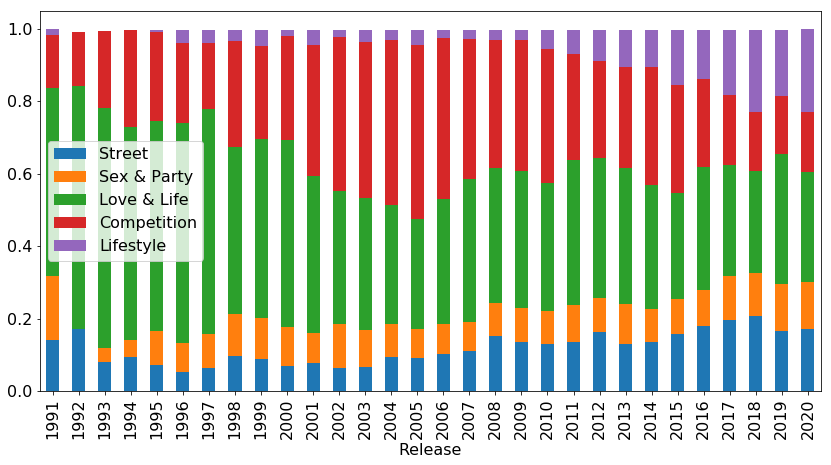

In [37]:
topics_by_release.plot.bar(stacked=True)

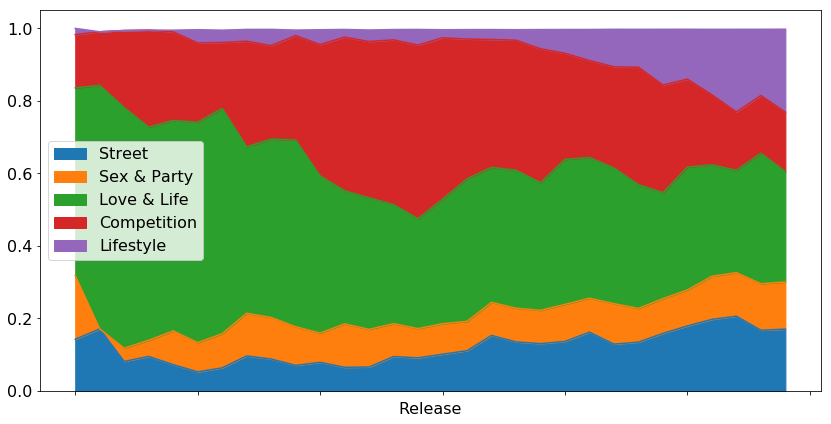

In [38]:
topics_by_release.plot.area(sharex=False)

In [25]:
topics_by_artist = all_songs.groupby(['Artist']).mean()
topics_by_artist = topics_by_artist.drop(columns=['Label'])

In [280]:
df_ = pd.DataFrame(transformed_topics, index=topics_by_artist.index)
dist_df = pd.DataFrame(distance_matrix(df_.values, df_.values), index = df_.index, columns = df_.index)
artist_med = dist_df.median().median()

def assert_artist_relation(artist_1, artist_2, positive=True):
    dist = dist_df[artist_1][artist_2]
    print((dist < artist_med) == positive)
    print(f'The median distance between all artists is {artist_med}')
    print(f'The distance between {artist_1} and {artist_2} is {dist}')

In [283]:
assert_artist_relation('Azad', 'Bushido')
assert_artist_relation('Capital Bra', 'Samra')
assert_artist_relation('Bonez MC', 'RAF Camora')
assert_artist_relation('Bonez MC', 'Gzuz')
assert_artist_relation('187 Strassenbande', 'Gzuz')
assert_artist_relation('Apache 207', 'Bausa')
assert_artist_relation('Samy Deluxe', 'Kool Savas')
assert_artist_relation('K.I.Z', 'Trailerpark')
assert_artist_relation('Trailerpark', 'Alligatoah')
assert_artist_relation('Shindy', 'Fler')
assert_artist_relation('Eno', 'Fero47')
assert_artist_relation('Jan Delay', 'Peter Fox')

True
The median distance between all artists is 0.2501542055268841
The distance between Azad and Bushido is 0.06855219915699752
True
The median distance between all artists is 0.2501542055268841
The distance between Capital Bra and Samra is 0.17098828730411192
True
The median distance between all artists is 0.2501542055268841
The distance between Bonez MC and RAF Camora is 0.1952578114552474
True
The median distance between all artists is 0.2501542055268841
The distance between Bonez MC and Gzuz is 0.0825440805149859
True
The median distance between all artists is 0.2501542055268841
The distance between 187 Strassenbande and Gzuz is 0.09501600069988093
True
The median distance between all artists is 0.2501542055268841
The distance between Apache 207 and Bausa is 0.07164344216189913
True
The median distance between all artists is 0.2501542055268841
The distance between Samy Deluxe and Kool Savas is 0.1861426230703238
True
The median distance between all artists is 0.2501542055268841
The

In [ ]:
%matplotlib inline
font = {'family': 'DejaVu Sans',
        'size': 12}
plt.rc('font', **font)
plt.rcParams["figure.figsize"] = [20, 10]

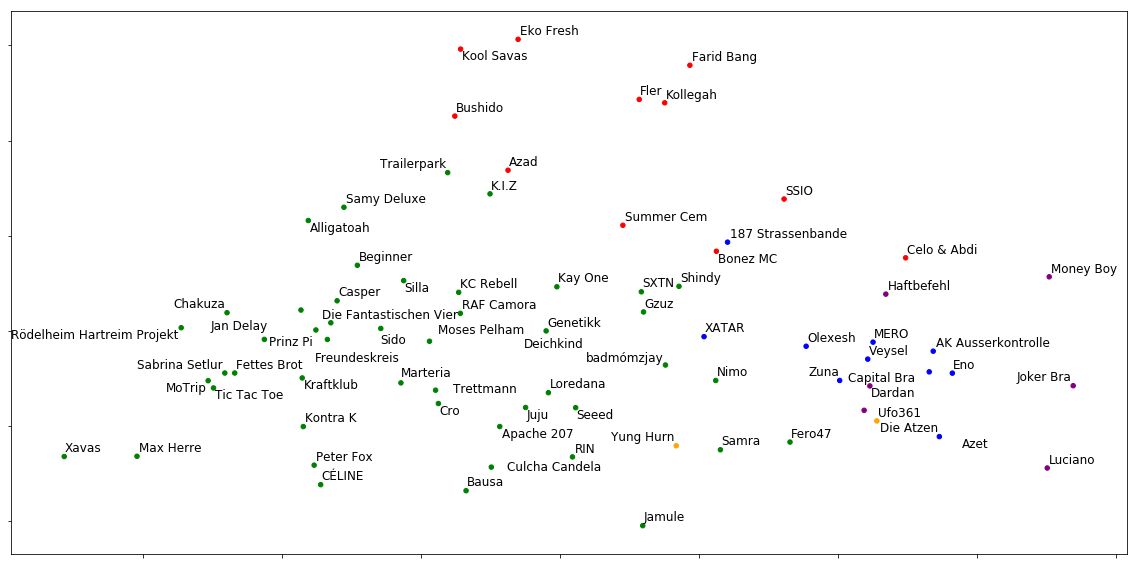

In [368]:
pca = sklearn.decomposition.PCA(n_components=2)
transformed_topics = pd.DataFrame(pca.fit_transform(topics_by_artist), index=topics_by_artist.index)

texts_ = []
main_colors = [(0,0,1), (1.0, 0.6470588235294118, 0.0), (0.0, 0.5019607843137255, 0.0), (1,0,0), (0.5019607843137255, 0.0, 0.5019607843137255)]
colors = []

for idx, row in topics_by_artist.iterrows():
    colors.append(main_colors[np.argmax(row.tolist())])

ax = transformed_topics.plot.scatter(x=0, y=1, c=colors)
for i, txt in enumerate(topics_by_artist.index):
    texts_.append(ax.annotate(txt, (transformed_topics.iloc[:,0].iat[i],transformed_topics.iloc[:,1].iat[i])))
    
adjust_text(texts_)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.show()

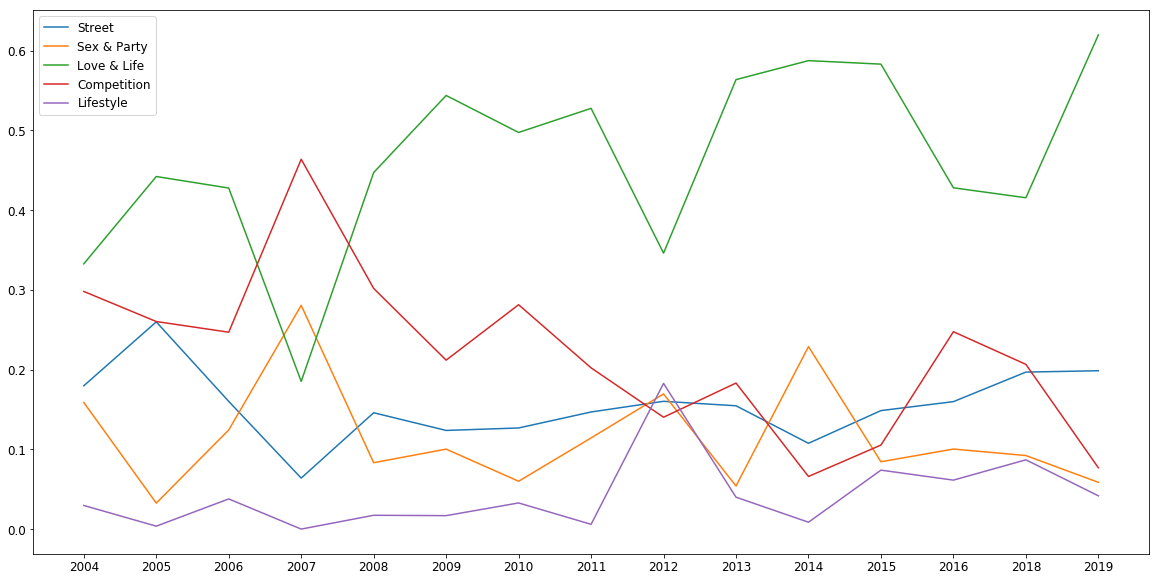

In [397]:
sido_ = all_songs[all_songs['Artist']=='Sido']
sido_ = sido_.groupby(['Release']).mean()
# only 4 songs in these 3 years, not meaningful
sido_ = sido_.drop(['1980', '2002', '2003'])
sido_ = sido_.drop(columns=['Label', 'Popularity'])
plt.plot(sido_)
plt.legend(['Street', 'Sex & Party', 'Love & Life', 'Competition', 'Lifestyle'])
plt.xticks(sido_.index)
plt.show()

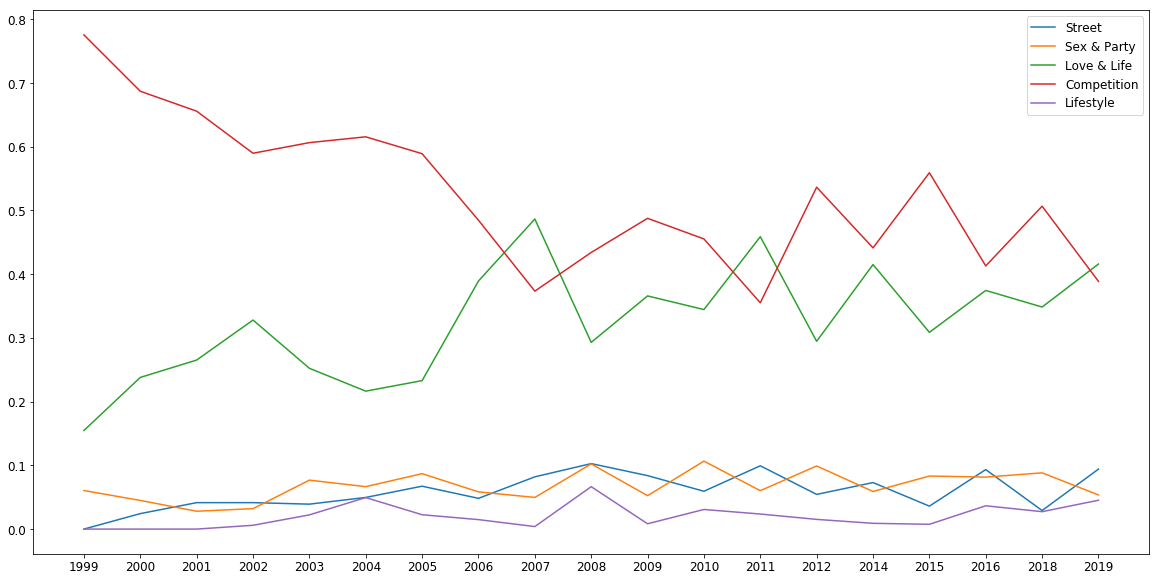

In [407]:
savas_ = all_songs[all_songs['Artist']=='Kool Savas']
savas_ = savas_.groupby(['Release']).mean()
# only 1 songs in 2020
savas_ = savas_.drop(['2020'])
savas_ = savas_.drop(columns=['Label', 'Popularity'])
plt.plot(savas_)
plt.legend(['Street', 'Sex & Party', 'Love & Life', 'Competition', 'Lifestyle'])
plt.xticks(savas_.index)
plt.show()

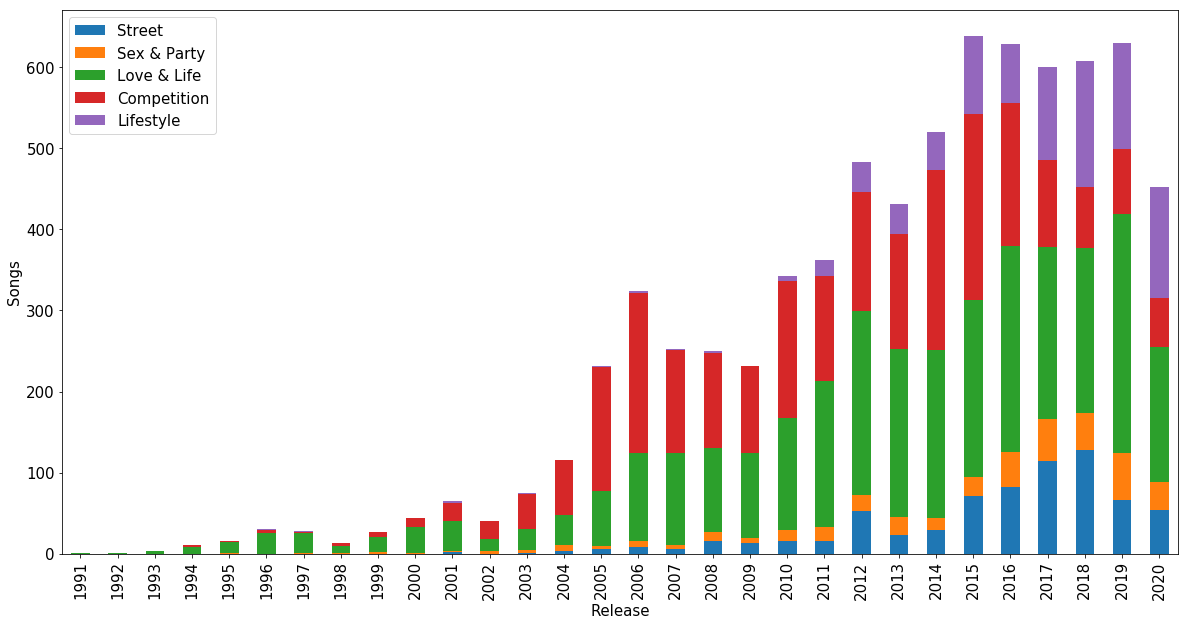

In [142]:
labels_by_release = all_songs.drop(columns=['Street', 'Sex & Party', 'Love & Life', 'Competition', 'Lifestyle', 'Artist', 'Title', 'Lyrics'])

labels_by_release = labels_by_release.groupby(['Release', 'Label'])['Label'].count()
labels_by_release = labels_by_release.drop(['0001', '1980', '2021'])
ax = pd.DataFrame(labels_by_release).unstack(level=1).plot.bar(stacked=True)
ax.set_ylabel('Songs')
ax.legend(['Street', 'Sex & Party', 'Love & Life', 'Competition', 'Lifestyle'])

In [428]:
%matplotlib inline
font = {'family': 'DejaVu Sans',
        'size': 18}
plt.rc('font', **font)
plt.rcParams["figure.figsize"] = [15, 7]

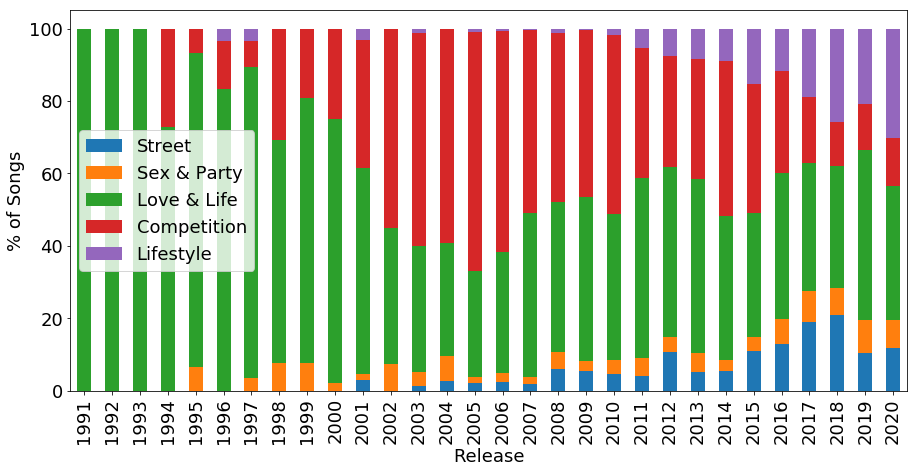

In [429]:
norm_lbr = pd.DataFrame(labels_by_release).unstack(level=1).fillna(0)

for idx, row in norm_lbr.iterrows():
    row = row.copy()
    norm_lbr.loc[idx] = row/sum(row)*100
    
ax = norm_lbr.plot.bar(stacked=True)
ax.set_ylabel('% of Songs')
ax.legend(['Street', 'Sex & Party', 'Love & Life', 'Competition', 'Lifestyle'])
plt.savefig("report/figures/timeline.pdf", bbox_inches="tight")
plt.show()

In [ ]:
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id="9e57eb45ef384c71944be64132ebb78d",
                                                           client_secret="d56cc78dbab64789a105cbf8769574bb"))

popularities = []

for idx, song in all_songs.iterrows():
    artist = song['Artist']
    title = song['Title']
    query = f'{artist} {title}'
    results = sp.search(q=query, limit=1, market='DE')
    if results['tracks']['items'] != []:
        popularity = results['tracks']['items'][0]['popularity']
    else:
        # fallback to just searching the title
        results = sp.search(q=title, limit=1, market='DE')
        if results['tracks']['items'] != []:
            popularity = results['tracks']['items'][0]['popularity']
        else:
            # fallback to setting popularity to 0
            popularity = 0
    popularities.append(popularity)

In [204]:
all_songs['Popularity'] = popularities

In [206]:
# Save the dataframe in a file for later use
#all_songs.to_pickle('all_songs.pkl')

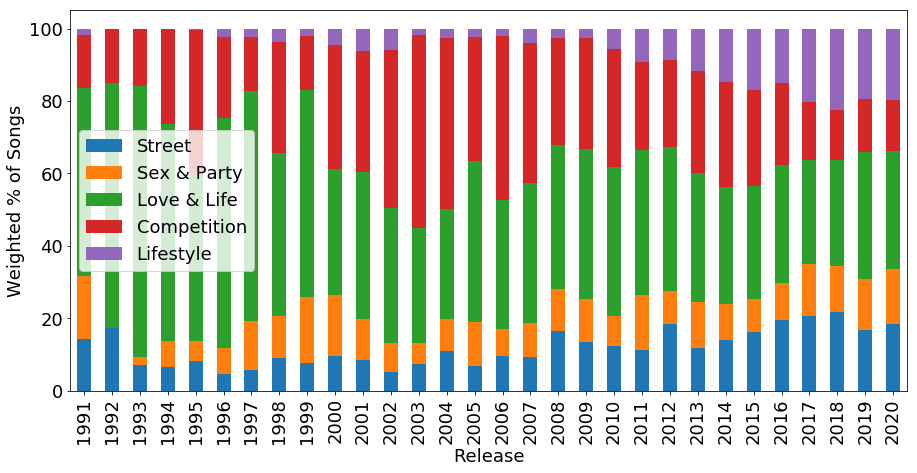

In [431]:
sbr_weighted = all_songs.copy()
weight_strength = math.pow(10, (3/100))
sbr_weighted['Popularity'] = sbr_weighted['Popularity'].map(lambda weight: math.pow(weight_strength, weight))
sbr_weighted['Street'] = sbr_weighted['Street']*sbr_weighted['Popularity']
sbr_weighted['Sex & Party'] = sbr_weighted['Sex & Party']*sbr_weighted['Popularity']
sbr_weighted['Love & Life'] = sbr_weighted['Love & Life']*sbr_weighted['Popularity']
sbr_weighted['Competition'] = sbr_weighted['Competition']*sbr_weighted['Popularity']
sbr_weighted['Lifestyle'] = sbr_weighted['Lifestyle']*sbr_weighted['Popularity']
sbr_weighted = sbr_weighted.groupby(['Release']).mean()
sbr_weighted = sbr_weighted.drop(['0001','1980', '2021'])
sbr_weighted = sbr_weighted.drop(columns=['Label', 'Popularity'])

for idx, row in sbr_weighted.iterrows():
    row = row.copy()
    sbr_weighted.loc[idx] = row/sum(row)*100
    
ax = sbr_weighted.plot.bar(stacked=True)
ax.set_ylabel('Weighted % of Songs')
ax.legend(loc='center left')
plt.savefig("report/figures/w_timeline.pdf", bbox_inches="tight")
plt.show()

In [408]:
#print(all_songs[all_songs['Title'].str.contains(' \(.*?\)')])
x_ = all_songs[all_songs['Artist']=='Kool Savas']
x_[x_['Release']=='2007']
#print(all_songs.iloc[8]['Lyrics'])
#print(all_songs.head())

,Title,Artist,Release,Lyrics,Label,Street,Sex & Party,Love & Life,Competition,Lifestyle,Popularity
4414,Alle schieben Optik,Kool Savas,2007,": Hey Hey Entschuldigung, Savas ja was is mit ...",3,0.027244,0.071320,0.153130,0.741678,0.000000,39
4440,Der Beweis,Kool Savas,2007,"Ihr wolltet mir nicht glauben, als ich meinte...",3,0.033339,0.067731,0.431136,0.464456,0.000000,43
4457,Essah,Kool Savas,2007,"Meine Damen und Herrn Essah, Essah Ich präse...",3,0.000000,0.042629,0.378326,0.567460,0.000000,38
4490,Krank,Kool Savas,2007,Wir sind krank und ich mein' nicht den Rap au...,2,0.124494,0.000000,0.820615,0.050762,0.000000,28
4507,Melodie,Kool Savas,2007,"Ich weiß, sie wünschen sich, ich würde einfac...",2,0.012346,0.153492,0.599051,0.191595,0.043515,27
4509,Mona Lisa,Kool Savas,2007,"Ich komm' auf die Bühne, leg' Hand ans Mic Fa...",3,0.163386,0.063283,0.207392,0.562814,0.000000,43
4520,Nur ein Spiel,Kool Savas,2007,"Ich kann nicht nochmal reseten, mein Leben zu...",2,0.153779,0.038134,0.427853,0.376897,0.000000,28
4524,On Top,Kool Savas,2007,"Du bist on Top, my man Du hast einfach, was ...",2,0.093105,0.000000,0.823115,0.078316,0.000000,33
4528,Orakel,Kool Savas,2007,"Guck dich an, du bist nicht wirklich mehr als...",2,0.122989,0.020668,0.483201,0.369796,0.000000,27
4556,Tot oder Lebendig,Kool Savas,2007,Dieser Rhyme hier entsteht grad auf 'ner Sour...,2,0.058218,0.073746,0.579085,0.285998,0.000000,43
